A look into using trying to classify reviews by their style by looking at vectorized terms relative to their counts and frequencies.

A first pass shows that with the dataset as is, there is a lot of noise in the classification.

In [47]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score

In [49]:
pg_pass = os.environ['BEER_DB']
engine = create_engine(pg_pass)
pd.read_sql("SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname='public' LIMIT 5", con=engine)

,tablename
0,spatial_ref_sys
1,SequelizeMeta
2,breweries
3,styles
4,reviews


In [50]:
reviews_by_style_count = """
SELECT
styles.name,
COUNT(styles.name)
FROM reviews, styles, beers
WHERE reviews.beer_id = beers.id
AND beers.style_id = styles.id
AND reviews.review_text IS NOT NULL
GROUP BY styles.name
HAVING COUNT(styles.name) > 10000
ORDER BY COUNT DESC;
"""

reviews_count = pd.read_sql(reviews_by_style_count, con=engine)

In [51]:
reviews_count.shape

(34, 2)

In [52]:
reviews_count['count']

0     216343
1     113927
2      81358
3      60405
4      52593
5      45510
6      42964
7      42848
8      32149
9      32122
10     23753
11     23468
12     22627
13     21538
14     20802
15     19882
16     19819
17     19629
18     17137
19     16356
20     15151
21     14923
22     14857
23     14757
24     13788
25     13507
26     12477
27     11989
28     11931
29     11886
30     11348
31     10821
32     10195
33     10019
Name: count, dtype: int64

In [53]:
reviews_count.head()

,name,count
0,American IPA,216343
1,American Imperial IPA,113927
2,American Pale Ale (APA),81358
3,American Imperial Stout,60405
4,Belgian Saison,52593


In [54]:
reviews_count.tail()

,name,count
29,Bohemian Pilsener,11886
30,Leipzig Gose,11348
31,English Brown Ale,10821
32,German Maibock,10195
33,Irish Red Ale,10019


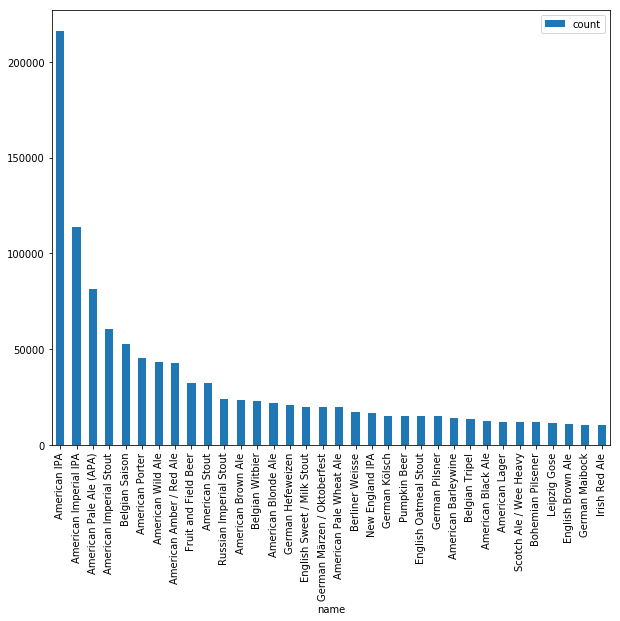

In [55]:
reviews_count.plot(kind="bar", x="name", figsize=(10,8))

In [57]:
reviews_query = """
SELECT 
reviews.review_text,
styles.name as target,
styles.id as target_id
FROM reviews, styles, beers
WHERE reviews.beer_id = beers.id
AND beers.style_id = styles.id
AND reviews.review_text IS NOT NULL
AND reviews.review_text !=''
LIMIT 17000;
"""

reviews = pd.read_sql(reviews_query, con=engine)
reviews.head()

,review_text,target,target_id
0,A - pours a complete ptich black with a 1/4 in...,American Porter,19
1,"Draft at the brewery.\nBlackish brown body, de...",American Black Ale,21
2,"I know of the backlash of their ""sellout"" to A...",Leipzig Gose,27
3,Poured from the tap into an 11 OZ tulip glass ...,Leipzig Gose,27
4,"12 oz. bottle,\nA: Pours amber with a full, fl...",German Märzen / Oktoberfest,16


In [83]:
tfidf = TfidfVectorizer(min_df=.05, max_df=0.5, ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(reviews.review_text).toarray()
labels = reviews.target_id
features.shape

(17000, 181)

In [84]:
number_of_terms = 2

styles_to_id = dict(zip(reviews.target, reviews.target_id))

for style, style_id in sorted(styles_to_id.items()):
    features_chi2 = chi2(features, labels == style_id)    
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # Aggregate results
    # Make word cloud?
    # Or at least subplots
    print(f"{style}:")
    print(f"Most correlated unigrams: { ' '.join(unigrams[-number_of_terms:]) }") 
    print(f"Most correlated bigrams: { ', '.join(bigrams[-number_of_terms:])  }")
    [print() for _ in range(4)]

American Adjunct Lager:
Most correlated unigrams: grain yellow
Most correlated bigrams: medium bodied, medium body




American Amber / Red Ale:
Most correlated unigrams: amber red
Most correlated bigrams: tan head, pint glass




American Amber / Red Lager:
Most correlated unigrams: red amber
Most correlated bigrams: white head, medium body




American Barleywine:
Most correlated unigrams: red alcohol
Most correlated bigrams: tan head, pint glass




American Black Ale:
Most correlated unigrams: roasted black
Most correlated bigrams: white head, tan head




American Blonde Ale:
Most correlated unigrams: honey ale
Most correlated bigrams: medium body, tan head




American Brett:
Most correlated unigrams: sour tart
Most correlated bigrams: white head, tan head




American Brown Ale:
Most correlated unigrams: tan brown
Most correlated bigrams: white head, tan head




American Brut IPA:
Most correlated unigrams: ipa dry
Most correlated bigrams: tan head, medium bodied




American Cr

German Kristalweizen:
Most correlated unigrams: lemon wheat
Most correlated bigrams: white head, pint glass




German Kölsch:
Most correlated unigrams: grassy light
Most correlated bigrams: tan head, white head




German Maibock:
Most correlated unigrams: malty alcohol
Most correlated bigrams: medium bodied, white head




German Märzen / Oktoberfest:
Most correlated unigrams: toasted caramel
Most correlated bigrams: medium body, white head




German Pilsner:
Most correlated unigrams: gold crisp
Most correlated bigrams: tan head, white head




German Rauchbier:
Most correlated unigrams: amber red
Most correlated bigrams: tan head, white head




German Roggenbier:
Most correlated unigrams: hops vanilla
Most correlated bigrams: white head, tan head




German Schwarzbier:
Most correlated unigrams: black roasted
Most correlated bigrams: medium body, tan head




German Weizenbock:
Most correlated unigrams: lots going
Most correlated bigrams: medium bodied, pint glass




Herb and Spi

In [85]:
X_train, X_test, y_train, y_test = train_test_split(reviews.review_text, reviews.target_id, random_state = 42)

for i in np.linspace(.5,.95,10):
    for j in np.linspace(0.05,0.2,10):
        tfidf = TfidfVectorizer(stop_words="english", max_df=i, min_df=j)
        X_train_tfidf = tfidf.fit_transform(X_train)
        mnb = MultinomialNB().fit(X_train_tfidf, y_train)
        bnb = BernoulliNB().fit(X_train_tfidf, y_train)

        mnb_predictions = mnb.predict(tfidf.transform(X_test))
        bnb_predictions = bnb.predict(tfidf.transform(X_test))
    
        # Aggregate results
        # Make word cloud?
        # Or at least subplots
        mnb_acc_score = accuracy_score(y_test, mnb_predictions)
        print(f"Multinomial Naive Bayes Classifier with tfidf max_df: {i} and min_df: {j}")
        print(f"Score is: {mnb_acc_score}")
        [print() for _ in range(4)]
        
        bnb_acc_score = accuracy_score(y_test, bnb_predictions)
        print(f"Bernoulli Naive Bayes Classifier with tfidf max_df: {i} and min_df: {j}")
        print(f"Score is: {bnb_acc_score}")
        [print() for _ in range(4)]

Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.05
Score is: 0.23576470588235293




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.05
Score is: 0.28894117647058826




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.06666666666666668
Score is: 0.2124705882352941




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.06666666666666668
Score is: 0.25976470588235295




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.08333333333333334
Score is: 0.1971764705882353




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.08333333333333334
Score is: 0.2555294117647059




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.1
Score is: 0.18964705882352942




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.1
Score is: 0.23576470588235293




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.116666666

Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.13333333333333336
Score is: 0.16211764705882353




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.13333333333333336
Score is: 0.18564705882352942




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.15000000000000002
Score is: 0.16141176470588237




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.15000000000000002
Score is: 0.1804705882352941




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.16666666666666669
Score is: 0.156




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.16666666666666669
Score is: 0.16494117647058823




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.18333333333333335
Score is: 0.15505882352941178




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.18333333333333335
Score is: 0.14211764705882354




Multinomial Naive Bayes

Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.05
Score is: 0.23529411764705882




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.05
Score is: 0.2842352941176471




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.06666666666666668
Score is: 0.2124705882352941




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.06666666666666668
Score is: 0.25270588235294117




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.08333333333333334
Score is: 0.19741176470588234




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.08333333333333334
Score is: 0.2510588235294118




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.1
Score is: 0.18964705882352942




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.1
Score is: 0.23294117647058823




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.

c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

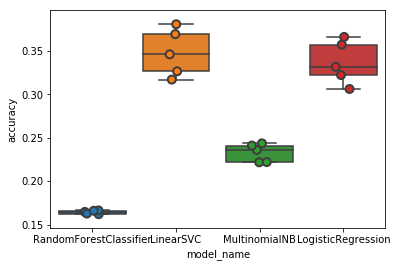

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

# This is one of the
# most gangster pieces of code
# I have ever seen

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    # Nice Dunder methods...
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    # We are grabbing the index and the scores for each model
    # And then appending to a list a tuple with the name, index, and scores
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# 
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [87]:
cv_df.groupby('model_name').accuracy.mean()

# How about a binary classification?

# https://www.businessinsider.com/everything-you-need-to-know-about-beer-in-one-chart-2015-8
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

model_name
LinearSVC                 0.348031
LogisticRegression        0.336768
MultinomialNB             0.232924
RandomForestClassifier    0.164361
Name: accuracy, dtype: float64

In [88]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [89]:
user_sim_query = """
SELECT 
review_profilename, 
AVG(review_overall) AS overall, 
beers.name as beer_name, 
breweries.name as brewery_name, 
styles.name as style 
FROM 
reviews, beers, breweries, styles 
WHERE reviews.beer_id = beers.id 
AND beers.style_id = styles.id 
AND beers.brewery_id = breweries.id 
GROUP BY review_profilename, 
style, beer_name, brewery_name 
HAVING AVG(review_overall) > 3.5
AND COUNT(review_profilename) > 10;
"""


user_reviews_grouped = pd.read_sql(user_sim_query, con=engine)

In [90]:
user_reviews_grouped.isnull().sum()

review_profilename    0
overall               0
beer_name             0
brewery_name          0
style                 0
dtype: int64

In [91]:
user_reviews_grouped.head()

,review_profilename,overall,beer_name,brewery_name,style
0,10Crumra,3.75,Milk Chocolate Stout,Rock Bottom Restaurant and Brewery,English Sweet / Milk Stout
1,1971bernat,4.00,Zug Zwang,Granite City Food & Brewery,American Porter
2,1971bernat,4.00,Blue Brunette,Granite City Food & Brewery,English Oatmeal Stout
3,1971bernat,4.00,Broad Axe Stout,Granite City Food & Brewery,English Oatmeal Stout
4,1971bernat,4.50,Elf's Tale,Granite City Food & Brewery,Winter Warmer


In [101]:
user_reviews_grouped.tail()

,review_profilename,overall,beer_name,brewery_name,style
2325,Zetcha7x,3.75,Kolsch,Rock Bottom Restaurant and Brewery,German Kölsch
2326,Zetcha7x,3.75,Red Rocks Red,Rock Bottom Restaurant and Brewery,Irish Red Ale
2327,zimm421,3.75,Gordon Biersch Winter Bock,Gordon Biersch Brewery & Restaurant,German Doppelbock
2328,zook74,4.00,American Dream Ale,Rock Bottom Restaurant and Brewery,American IPA
2329,zsk,5.00,Gordon Biersch Kölsch,Gordon Biersch Brewery & Restaurant,German Kölsch


In [104]:
user_reviews_grouped.groupby(["review_profilename","style","beer_name"])["overall"].mean()

review_profilename  style                        beer_name                         
10Crumra            English Sweet / Milk Stout   Milk Chocolate Stout                  3.75
1971bernat          American Porter              Zug Zwang                             4.00
                    English Oatmeal Stout        Blue Brunette                         4.00
                                                 Broad Axe Stout                       4.00
                    Winter Warmer                Elf's Tale                            4.50
22Blue              Belgian Tripel               Belgian Tripel                        3.75
773-F-I-B           Pumpkin Beer                 The Wicked Brewski                    3.75
AC-Mivsek           Belgian Tripel               Belgian Tripel                        3.75
ADR                 English Oatmeal Stout        Rock Bottom Oatmeal Stout             4.00
                    Russian Imperial Stout       Black Bull Imperial Stout             4

In [105]:
# TODO USER TO USER recommendation

# # We'll use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)